# Semantic Retrieval for Scientific Documents

This notebook implements a deep learning-based semantic retrieval system, trained and evaluated on the SciFact dataset.

## Project Overview
- Fine-tune embedding models using sentence-transformers
- Use MultipleNegativesRankingLoss loss function
- Train and evaluate on BEIR-format datasets
- Compare with traditional methods like BM25

## 1. Environment Setup and Dependencies

In [1]:
# If running in Colab, uncomment the line below to install dependencies
!pip install sentence-transformers datasets pandas scikit-learn torch accelerate beir

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.4/77.4 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.8/304.8 kB 13.7 MB/s eta 0:00:00


In [2]:
import logging
import json
import math
from pathlib import Path
from collections import defaultdict
from typing import Dict, Set, List, Tuple, Optional, Any, Union
import pandas as pd
from sklearn.model_selection import train_test_split

# Setup logging
logging.basicConfig(
    format="%(asctime)s - %(levelname)s - %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    level=logging.INFO,
)
logger = logging.getLogger(__name__)

## 2. Data Loading and Preprocessing

We use the BeIR/scifact-generated-queries dataset, a scientific literature retrieval dataset.

In [3]:
def load_scifact_raw(output_dir: str = "./data/raw"):
    """
    Load BeIR/scifact-generated-queries dataset from HuggingFace
    """
    from datasets import load_dataset

    raw_dir = Path(output_dir)
    raw_dir.mkdir(parents=True, exist_ok=True)

    # Load dataset
    logger.info("Loading SciFact dataset from HuggingFace...")
    ds = load_dataset("BeIR/scifact-generated-queries")
    df = ds["train"].to_pandas()  # type: ignore

    # Save raw data
    raw_path = raw_dir / "scifact_raw.csv"
    df.to_csv(raw_path, index=False)  # type: ignore
    logger.info(f"Raw data saved to {raw_path}")
    logger.info(f"Dataset size: {len(df)} rows")  # type: ignore

    return df  # type: ignore

In [4]:
def preprocess_scifact(raw_df: pd.DataFrame, output_dir: str = "./data/processed"):
    """
    Preprocess SciFact dataset and generate BEIR-format training data

    Output files:
    - scifact_pairs.csv: Query-document pairs
    - scifact_corpus.csv: Deduplicated document corpus
    - beir_format/corpus.jsonl: BEIR-format corpus
    - beir_format/queries.jsonl: BEIR-format queries
    - beir_format/qrels/train.tsv: Training set relevance labels (70%)
    - beir_format/qrels/dev.tsv: Validation set relevance labels (10%)
    - beir_format/qrels/test.tsv: Test set relevance labels (20%)
    """
    processed_dir = Path(output_dir)
    processed_dir.mkdir(parents=True, exist_ok=True)

    # Process data
    df = raw_df[["_id", "title", "text", "query"]].copy()
    df = df.dropna(subset=["text", "query"])  # type: ignore
    df = df.rename(columns={"_id": "doc_id"})

    # Data cleaning
    df["title"] = df["title"].fillna("").astype(str).str.strip()
    df["text"] = df["text"].fillna("").astype(str).str.strip()
    df["query"] = df["query"].astype(str).str.strip()

    # Combine title and text
    df["content"] = df["title"] + ". " + df["text"]

    # Assign ID to each unique query
    df = df.reset_index(drop=True)
    df["query_id"] = pd.factorize(df["query"])[0]

    # Save query-document pairs
    pairs_path = processed_dir / "scifact_pairs.csv"
    df.to_csv(pairs_path, index=False)
    logger.info(f"Query-doc pairs saved to {pairs_path}")

    # Save deduplicated corpus
    corpus = (
        df[["doc_id", "content"]]
        .drop_duplicates(subset=["doc_id"])  # type: ignore
        .reset_index(drop=True)
    )
    corpus_path = processed_dir / "scifact_corpus.csv"
    corpus.to_csv(corpus_path, index=False)
    logger.info(f"Corpus saved to {corpus_path} ({len(corpus)} documents)")

    # Create BEIR-format data
    beir_dir = processed_dir / "beir_format"
    beir_dir.mkdir(parents=True, exist_ok=True)
    qrels_dir = beir_dir / "qrels"
    qrels_dir.mkdir(parents=True, exist_ok=True)

    # Write corpus.jsonl
    corpus_jsonl_path = beir_dir / "corpus.jsonl"
    with open(corpus_jsonl_path, "w", encoding="utf-8") as f:
        for _, row in corpus.iterrows():
            doc = {
                "_id": str(row["doc_id"]),
                "text": row["content"],
                "title": "",
            }
            f.write(json.dumps(doc, ensure_ascii=False) + "\n")
    logger.info(f"BEIR corpus saved to {corpus_jsonl_path}")

    # Write queries.jsonl
    queries_jsonl_path = beir_dir / "queries.jsonl"
    unique_queries = df[["query_id", "query"]].drop_duplicates(subset=["query_id"])  # type: ignore
    with open(queries_jsonl_path, "w", encoding="utf-8") as f:
        for _, row in unique_queries.iterrows():
            query = {"_id": str(row["query_id"]), "text": row["query"]}
            f.write(json.dumps(query, ensure_ascii=False) + "\n")
    logger.info(f"BEIR queries saved to {queries_jsonl_path}")

    # Split into train/dev/test sets (70/10/20)
    unique_query_ids = df["query_id"].unique()
    train_dev_query_ids, test_query_ids = train_test_split(
        unique_query_ids, test_size=0.2, random_state=42
    )
    train_query_ids, dev_query_ids = train_test_split(
        train_dev_query_ids, test_size=0.125, random_state=42
    )

    train_df = df[df["query_id"].isin(train_query_ids)]
    dev_df = df[df["query_id"].isin(dev_query_ids)]
    test_df = df[df["query_id"].isin(test_query_ids)]

    # Write qrels files
    for split_name, split_df in [
        ("train", train_df),
        ("dev", dev_df),
        ("test", test_df),
    ]:
        qrels_path = qrels_dir / f"{split_name}.tsv"
        with open(qrels_path, "w", encoding="utf-8") as f:
            for _, row in split_df.iterrows():
                f.write(f"{row['query_id']}\t{row['doc_id']}\t1\n")
        logger.info(f"{split_name} qrels saved to {qrels_path} ({len(split_df)} pairs)")

    logger.info(f"\nData preprocessing completed!")
    logger.info(f"Train: {len(train_query_ids)} queries, {len(train_df)} pairs")
    logger.info(f"Dev: {len(dev_query_ids)} queries, {len(dev_df)} pairs")
    logger.info(f"Test: {len(test_query_ids)} queries, {len(test_df)} pairs")

    return beir_dir

## 3. Data Loading Utilities

In [5]:
def load_qrels(qrels_path: Path) -> Dict[str, Set[str]]:
    """Load qrels file and return query_id -> {doc_ids} mapping"""
    query_to_docs = defaultdict(set)

    with open(qrels_path, "r", encoding="utf-8") as f:
        for line in f:
            parts = line.strip().split("\t")
            if len(parts) >= 2:
                query_id = parts[0]
                doc_id = parts[1]
                query_to_docs[query_id].add(doc_id)

    return dict(query_to_docs)


def load_queries(queries_path: Path) -> Dict[str, str]:
    """Load queries.jsonl file and return query_id -> query_text mapping"""
    queries = {}

    with open(queries_path, "r", encoding="utf-8") as f:
        for line in f:
            query = json.loads(line)
            queries[query["_id"]] = query["text"]

    return queries


def load_corpus(corpus_path: Path) -> Dict[str, str]:
    """Load corpus.jsonl file and return doc_id -> doc_text mapping"""
    corpus = {}

    with open(corpus_path, "r", encoding="utf-8") as f:
        for line in f:
            doc = json.loads(line)
            corpus[doc["_id"]] = doc["text"]

    return corpus

## 4. Model Training

Fine-tune embedding models using sentence-transformers library with MultipleNegativesRankingLoss.

In [6]:
# Training configuration
MODEL_NAME = "BAAI/bge-small-en-v1.5"  # Base model
BATCH_SIZE = 64
EPOCHS = 5
WARMUP_RATIO = 0.1
LEARNING_RATE = 3e-5
OUTPUT_DIR = "/content/drive/semantic-retrieval/models/finetuned-mnrl"

IN_COLAB = "google.colab" in str(get_ipython())
if IN_COLAB:
    from google.colab import drive

    drive.mount("/content/drive")

    BASE_DIR = Path("/content/drive/MyDrive/semantic-retrieval")
    OUTPUT_DIR = str(BASE_DIR / "models/finetuned-mnrl")
    DATA_DIR = str(BASE_DIR / "data")
    RESULTS_DIR = str(BASE_DIR / "results")
else:
    BASE_DIR = Path(".")
    OUTPUT_DIR = "./models/finetuned-mnrl"
    DATA_DIR = "./data"
    RESULTS_DIR = "./results"

Mounted at /content/drive


In [7]:
def load_training_data(data_dir: Path) -> list:
    """
    Load training data and convert to InputExample format

    For MultipleNegativesRankingLoss, we only need (query, positive_doc) pairs.
    Negative samples are drawn from other examples in the same batch.
    """
    from sentence_transformers import InputExample

    qrels_path = data_dir / "qrels" / "train.tsv"
    queries_path = data_dir / "queries.jsonl"
    corpus_path = data_dir / "corpus.jsonl"

    logger.info("Loading training data...")
    query_to_docs = load_qrels(qrels_path)
    queries = load_queries(queries_path)
    corpus = load_corpus(corpus_path)

    # Create training examples
    examples = []
    for query_id, doc_ids in query_to_docs.items():
        if query_id not in queries:
            continue

        query_text = queries[query_id]

        for doc_id in doc_ids:
            if doc_id not in corpus:
                continue

            doc_text = corpus[doc_id]
            examples.append(InputExample(texts=[query_text, doc_text]))

    logger.info(f"Created {len(examples)} training examples")
    return examples


def create_evaluator(data_dir: Path, split: str = "dev"):
    """
    Create InformationRetrievalEvaluator for validation during training
    """
    from sentence_transformers.evaluation import InformationRetrievalEvaluator

    qrels_path = data_dir / "qrels" / f"{split}.tsv"
    queries_path = data_dir / "queries.jsonl"
    corpus_path = data_dir / "corpus.jsonl"

    logger.info(f"Loading {split} data for evaluation...")
    query_to_docs = load_qrels(qrels_path)
    queries = load_queries(queries_path)
    corpus = load_corpus(corpus_path)

    # Filter queries and documents
    eval_queries = {qid: queries[qid] for qid in query_to_docs if qid in queries}
    eval_corpus = corpus

    # Convert qrels format
    eval_qrels: Dict[str, Set[str]] = {
        qid: set(doc_ids)
        for qid, doc_ids in query_to_docs.items()
        if qid in eval_queries
    }

    logger.info(f"Evaluator: {len(eval_queries)} queries, {len(eval_corpus)} documents")

    return InformationRetrievalEvaluator(
        queries=eval_queries,
        corpus=eval_corpus,
        relevant_docs=eval_qrels,
        name=split,
        ndcg_at_k=[10, 100],
        precision_recall_at_k=[10, 100],
        map_at_k=[100],
        mrr_at_k=[10],
        show_progress_bar=True,
    )

In [8]:
def train_model(data_dir: Path, output_dir: str = OUTPUT_DIR):
    """
    Train the embedding model
    """
    from sentence_transformers import SentenceTransformer, losses
    from torch.utils.data import DataLoader

    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)

    # Load model
    logger.info(f"Loading model: {MODEL_NAME}")
    model = SentenceTransformer(MODEL_NAME)

    # Load training data
    train_examples = load_training_data(data_dir)
    train_dataloader = DataLoader(
        train_examples,  # type: ignore
        shuffle=True,
        batch_size=BATCH_SIZE,
    )

    # Setup loss function
    train_loss = losses.MultipleNegativesRankingLoss(model)

    # Create validation evaluator
    dev_evaluator = create_evaluator(data_dir, split="dev")

    # Calculate training steps
    total_steps = len(train_dataloader) * EPOCHS
    warmup_steps = int(total_steps * WARMUP_RATIO)

    logger.info(f"\nTraining configuration:")
    logger.info(f"  Model: {MODEL_NAME}")
    logger.info(f"  Batch size: {BATCH_SIZE}")
    logger.info(f"  Epochs: {EPOCHS}")
    logger.info(f"  Total steps: {total_steps}")
    logger.info(f"  Warmup steps: {warmup_steps}")
    logger.info(f"  Learning rate: {LEARNING_RATE}")
    logger.info(f"  Output directory: {output_path}")

    # Start training
    logger.info("\nStarting training...")
    model.fit(
        train_objectives=[(train_dataloader, train_loss)],
        evaluator=dev_evaluator,
        epochs=EPOCHS,
        warmup_steps=warmup_steps,
        optimizer_params={"lr": LEARNING_RATE},
        output_path=str(output_path),
        evaluation_steps=len(train_dataloader) // 2,  # Evaluate twice per epoch
        save_best_model=True,
        show_progress_bar=True,
    )

    logger.info(f"\nTraining completed! Model saved to: {output_path}")

    # Final evaluation on test set
    logger.info("\nRunning final evaluation on test set...")
    test_evaluator = create_evaluator(data_dir, split="test")
    test_results = test_evaluator(model, output_path=str(output_path))

    logger.info("\n" + "=" * 50)
    logger.info("Final Test Results:")
    for metric, value in test_results.items():
        logger.info(f"  {metric}: {value:.4f}")
    logger.info("=" * 50)

    return model

## 5. Evaluation Metrics

Implement standard information retrieval evaluation metrics.

In [9]:
# Type alias for ground truth
GroundTruth = Union[str, List[str], Set[str]]

In [10]:
def traditional_eval(samples: List[Dict[str, Any]], k: int = 10) -> Dict[str, float]:
    """
    Evaluation for retrieval with single or multi-ground-truth.

    Args:
        samples: List of samples in the format:
            [{
                "question": str,
                "contexts": List[str],  # ranked top-K doc_ids
                "ground_truth": str | list | set  # gold doc_id(s)
            }]
        k: Cutoff position for evaluation

    Returns:
        Dictionary containing various metrics
    """

    def to_set(gt: GroundTruth) -> Set[str]:
        if isinstance(gt, set):
            return set(str(x) for x in gt)
        if isinstance(gt, list):
            return set(str(x) for x in gt)
        # single string / single id
        return {str(gt)}

    def hit_at_k(gt_set: Set[str], results: List[str], k: int) -> float:
        return 1.0 if any(r in gt_set for r in results[:k]) else 0.0

    def precision_at_k(gt_set: Set[str], results: List[str], k: int) -> float:
        if k <= 0:
            return 0.0
        hits = sum(1 for r in results[:k] if r in gt_set)
        return hits / k

    def recall_at_k(gt_set: Set[str], results: List[str], k: int) -> float:
        if not gt_set:
            return 0.0
        hits = sum(1 for r in results[:k] if r in gt_set)
        return hits / len(gt_set)

    def mrr(gt_set: Set[str], results: List[str]) -> float:
        for rank, r in enumerate(results, start=1):
            if r in gt_set:
                return 1.0 / rank
        return 0.0

    def average_precision_at_k(gt_set: Set[str], results: List[str], k: int) -> float:
        """
        AP@K for multi-relevant:
          AP = (1 / min(|GT|, K)) * sum_{i=1..K} Precision@i * rel_i
        """
        if not gt_set:
            return 0.0

        hits = 0
        s = 0.0
        for i, r in enumerate(results[:k], start=1):
            if r in gt_set:
                hits += 1
                s += hits / i
        return s / min(len(gt_set), k)

    def ndcg_at_k(gt_set: Set[str], results: List[str], k: int) -> float:
        # binary relevance
        dcg = 0.0
        for i, r in enumerate(results[:k], start=1):
            rel = 1.0 if r in gt_set else 0.0
            dcg += rel / math.log2(i + 1)

        # ideal DCG: all relevant docs first
        ideal_rels = [1.0] * min(len(gt_set), k)
        idcg = 0.0
        for i, rel in enumerate(ideal_rels, start=1):
            idcg += rel / math.log2(i + 1)

        return dcg / idcg if idcg > 0 else 0.0

    hits, precisions, recalls, mrrs, aps, ndcgs = [], [], [], [], [], []

    for s in samples:
        gt_set = to_set(s["ground_truth"])
        results = [str(x) for x in s["contexts"]]

        hits.append(hit_at_k(gt_set, results, k))
        precisions.append(precision_at_k(gt_set, results, k))
        recalls.append(recall_at_k(gt_set, results, k))
        mrrs.append(mrr(gt_set, results))
        aps.append(average_precision_at_k(gt_set, results, k))
        ndcgs.append(ndcg_at_k(gt_set, results, k))

    n = len(samples) if samples else 1
    return {
        f"Hit@{k}": sum(hits) / n,
        f"Precision@{k}": sum(precisions) / n,
        f"Recall@{k}": sum(recalls) / n,
        "MRR": sum(mrrs) / n,
        f"MAP@{k}": sum(aps) / n,
        f"NDCG@{k}": sum(ndcgs) / n,
        "N": float(len(samples)),
    }

In [11]:
def load_baseline_results(results_dir) -> Dict[str, Dict[str, Any]]:
    """
    Load baseline model results from JSON files

    Args:
        results_dir: Directory containing baseline result JSON files

    Returns:
        Dictionary mapping model name to results
    """
    results_path = Path(results_dir)
    baseline_results = {}

    if not results_path.exists():
        logger.warning(f"Results directory not found: {results_path}")
        return baseline_results

    # Load all JSON files in results directory
    for json_file in results_path.glob("*_results.json"):
        try:
            with open(json_file, "r", encoding="utf-8") as f:
                data = json.load(f)
                model_name = data.get("model_name", json_file.stem)
                baseline_results[model_name] = data
                logger.info(f"Loaded baseline results: {model_name}")
        except Exception as e:
            logger.warning(f"Failed to load {json_file.name}: {e}")

    return baseline_results


def display_baseline_comparison(baseline_results: Dict[str, Dict[str, Any]]):
    """
    Display comparison of baseline model results

    Args:
        baseline_results: Dictionary of baseline results from load_baseline_results
    """
    if not baseline_results:
        print(
            "No baseline results found. Please run baseline evaluation scripts first:"
        )
        print("  - uv run src/embedding_model/zero_shot.py")
        print("  - uv run src/run_word2vec_eval.py")
        return

    print("\n" + "=" * 80)
    print("BASELINE MODEL COMPARISON")
    print("=" * 80)

    # Collect all unique metrics
    all_metrics = set()
    for result in baseline_results.values():
        all_metrics.update(result.get("metrics", {}).keys())

    # Remove 'N' from comparison metrics
    all_metrics.discard("N")
    metric_list = sorted(all_metrics)

    # Display results table
    print(f"\n{'Model':<30}", end="")
    for metric in metric_list:
        print(f"{metric:>12}", end="")
    print()
    print("-" * 80)

    for model_name, result in baseline_results.items():
        metrics = result.get("metrics", {})
        print(f"{model_name:<30}", end="")
        for metric in metric_list:
            value = metrics.get(metric, 0.0)
            if isinstance(value, (int, float)):
                print(f"{value:>12.4f}", end="")
            else:
                print(f"{str(value):>12}", end="")
        print()

    print("=" * 80)

    # Display model details
    print("\nModel Details:")
    print("-" * 80)
    for model_name, result in baseline_results.items():
        print(f"\n{model_name}:")
        print(f"  Type: {result.get('model_type', 'N/A')}")
        if "base_model" in result:
            print(f"  Base Model: {result['base_model']}")
        if "parameters" in result:
            print(f"  Parameters: {result['parameters']}")
        if "N" in result.get("metrics", {}):
            print(f"  Test Samples: {int(result['metrics']['N'])}")
    print("-" * 80)

## 6. Complete Training and Evaluation Pipeline

Run the code below to execute the complete workflow.

In [12]:
# Step 1: Load raw data
logger.info("=" * 60)
logger.info("Step 1: Loading raw data")
logger.info("=" * 60)
raw_df = load_scifact_raw()

# Display sample data
logger.info("\nSample data:")
print(raw_df.head())  # type: ignore

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train.jsonl.gz:   0%|          | 0.00/3.43M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/15422 [00:00<?, ? examples/s]

    _id                                              title  \
0  4983  Microstructural development of human newborn c...   
1  4983  Microstructural development of human newborn c...   
2  4983  Microstructural development of human newborn c...   
3  5836  Induction of myelodysplasia by myeloid-derived...   
4  5836  Induction of myelodysplasia by myeloid-derived...   

                                                text  \
0  Alterations of the architecture of cerebral wh...   
1  Alterations of the architecture of cerebral wh...   
2  Alterations of the architecture of cerebral wh...   
3  Myelodysplastic syndromes (MDS) are age-depend...   
4  Myelodysplastic syndromes (MDS) are age-depend...   

                                               query  
0  what is the diffusion coefficient of cerebral ...  
1                           what is diffusion tensor  
2  what is the diffusion coefficient of the cereb...  
3  which type of hematopoiesis is characterized b...  
4              

In [13]:
# Step 2: Preprocess data
logger.info("\n" + "=" * 60)
logger.info("Step 2: Preprocessing data")
logger.info("=" * 60)
beir_dir = preprocess_scifact(raw_df)  # type: ignore

In [14]:
# Step 3: Train model
logger.info("\n" + "=" * 60)
logger.info("Step 3: Training model")
logger.info("=" * 60)

# Comment out the line below if you want to skip training
model = train_model(beir_dir)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 3


wandb: You chose "Don't visualize my results"


Step,Training Loss,Validation Loss,Dev Cosine Accuracy@1,Dev Cosine Accuracy@3,Dev Cosine Accuracy@5,Dev Cosine Accuracy@10,Dev Cosine Precision@10,Dev Cosine Precision@100,Dev Cosine Recall@10,Dev Cosine Recall@100,Dev Cosine Ndcg@10,Dev Cosine Ndcg@100,Dev Cosine Mrr@10,Dev Cosine Map@100
84,No log,No log,0.682055,0.842003,0.890767,0.934330,0.093888,0.009896,0.933680,0.984070,0.810709,0.821716,0.771593,0.772939
168,No log,No log,0.693758,0.857607,0.900520,0.941482,0.094668,0.009935,0.941157,0.987646,0.821735,0.831865,0.783457,0.784795
169,No log,No log,0.693758,0.857607,0.900520,0.941482,0.094668,0.009935,0.941157,0.987646,0.821463,0.831590,0.783115,0.784452
252,No log,No log,0.702861,0.860858,0.904421,0.943433,0.094863,0.009902,0.943108,0.984395,0.827480,0.836478,0.790351,0.791474
336,No log,No log,0.704811,0.862809,0.901170,0.942133,0.094733,0.009915,0.941808,0.985696,0.827557,0.836904,0.790682,0.792088
338,No log,No log,0.705462,0.864109,0.901170,0.942133,0.094733,0.009915,0.941808,0.985696,0.827504,0.836854,0.790629,0.792040
420,No log,No log,0.704161,0.857607,0.900520,0.942783,0.094863,0.009915,0.942783,0.985696,0.826741,0.835967,0.789398,0.790921
504,0.222900,No log,0.699610,0.860858,0.901821,0.942783,0.094798,0.009935,0.942458,0.987646,0.824913,0.834457,0.787051,0.788496
507,0.222900,No log,0.700260,0.861508,0.902471,0.942783,0.094863,0.009928,0.942783,0.986996,0.825253,0.834565,0.787364,0.788795
588,0.222900,No log,0.701560,0.856957,0.897919,0.937581,0.094343,0.009909,0.937581,0.985046,0.823157,0.833304,0.786177,0.787952


Batches:   0%|          | 0/49 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/162 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:08<00:00,  8.11s/it]


Batches:   0%|          | 0/49 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/162 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:08<00:00,  8.54s/it]


Batches:   0%|          | 0/49 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/162 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:08<00:00,  8.10s/it]


Batches:   0%|          | 0/49 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/162 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:08<00:00,  8.10s/it]


Batches:   0%|          | 0/49 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/162 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:08<00:00,  8.07s/it]


Batches:   0%|          | 0/49 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/162 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:08<00:00,  8.08s/it]


Batches:   0%|          | 0/49 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/162 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:08<00:00,  8.10s/it]


Batches:   0%|          | 0/49 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/162 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:08<00:00,  8.10s/it]


Batches:   0%|          | 0/49 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/162 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:08<00:00,  8.09s/it]


Batches:   0%|          | 0/49 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/162 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:08<00:00,  8.07s/it]


Batches:   0%|          | 0/49 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/162 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:08<00:00,  8.13s/it]


Batches:   0%|          | 0/49 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/162 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:08<00:00,  8.06s/it]


Batches:   0%|          | 0/49 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/162 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:08<00:00,  8.07s/it]


Batches:   0%|          | 0/49 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/162 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:08<00:00,  8.07s/it]


Batches:   0%|          | 0/49 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/162 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:08<00:00,  8.08s/it]


Batches:   0%|          | 0/97 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/162 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:08<00:00,  8.19s/it]


In [15]:
# Step 4: Load pre-trained model (if already trained)
# Comment out this section if you already trained above
# from sentence_transformers import SentenceTransformer
# model = SentenceTransformer(OUTPUT_DIR)
# logger.info(f"Model loaded from {OUTPUT_DIR}")

## 7. Semantic Retrieval with Trained Model

Demonstration of how to use the trained model for semantic retrieval.

In [16]:
def semantic_search_demo(model, data_dir: Path, num_queries: int = 5):
    """
    Demonstrate semantic search functionality
    """
    import numpy as np
    from sentence_transformers import util

    # Load test data
    queries_path = data_dir / "queries.jsonl"
    corpus_path = data_dir / "corpus.jsonl"
    qrels_path = data_dir / "qrels" / "test.tsv"

    queries = load_queries(queries_path)
    corpus = load_corpus(corpus_path)
    query_to_docs = load_qrels(qrels_path)

    # Encode corpus
    logger.info("Encoding corpus...")
    corpus_ids = list(corpus.keys())
    corpus_texts = [corpus[doc_id] for doc_id in corpus_ids]
    corpus_embeddings = model.encode(
        corpus_texts, convert_to_tensor=True, show_progress_bar=True
    )

    # Select test queries
    test_queries = list(query_to_docs.keys())[:num_queries]

    logger.info(f"\nRunning semantic search on {num_queries} test queries...")

    for query_id in test_queries:
        query_text = queries[query_id]
        ground_truth = query_to_docs[query_id]

        # Encode query
        query_embedding = model.encode(query_text, convert_to_tensor=True)

        # Compute similarity and retrieve
        cos_scores = util.cos_sim(query_embedding, corpus_embeddings)[0]
        top_results = np.argsort(-cos_scores.cpu().numpy())[:10]

        # Display results
        print("\n" + "=" * 80)
        print(f"Query: {query_text}")
        print(f"Ground truth docs: {ground_truth}")
        print("\nTop 10 retrieved documents:")

        for rank, idx in enumerate(top_results, 1):
            doc_id = corpus_ids[idx]
            score = cos_scores[idx].item()
            is_relevant = "✓" if doc_id in ground_truth else "✗"
            doc_preview = corpus[doc_id][:100] + "..."
            print(f"\n{rank}. [{is_relevant}] Doc {doc_id} (score: {score:.4f})")
            print(f"   {doc_preview}")

In [17]:
# Run retrieval demo
semantic_search_demo(model, beir_dir, num_queries=3)

Batches:   0%|          | 0/162 [00:00<?, ?it/s]


Query: what is the diffusion coefficient of cerebral white matter?
Ground truth docs: {'4983'}

Top 10 retrieved documents:

1. [✓] Doc 4983 (score: 0.8203)
   Microstructural development of human newborn cerebral white matter assessed in vivo by diffusion ten...

2. [✗] Doc 1412089 (score: 0.6804)
   Diminished performance on neuropsychological testing in late life depression is correlated with micr...

3. [✗] Doc 1472815 (score: 0.6409)
   Alterations of white matter integrity in adults with major depressive disorder: a magnetic resonance...

4. [✗] Doc 24148722 (score: 0.6406)
   A diffusion tensor magnetic resonance imaging study of corpus callosum from adult patients with migr...

5. [✗] Doc 7224632 (score: 0.6249)
   A longitudinal diffusion tensor imaging study assessing white matter fiber tracts after sports-relat...

6. [✗] Doc 25789730 (score: 0.5694)
   Diffusion tensor imaging detects and differentiates axon and myelin degeneration in mouse optic nerv...

7. [✗] Doc 221076

## 7.3. Load and Display Baseline Results

Before evaluating our fine-tuned model, let's load the baseline results for comparison.

**Note**: Make sure to run the baseline evaluation scripts first:
- `uv run src/embedding_model/zero_shot.py` - Zero-shot BGE baseline
- `uv run src/run_word2vec_eval.py` - Word2Vec baseline

In [18]:
# Load baseline results
logger.info("Loading baseline model results...")
baseline_results = load_baseline_results(results_dir=RESULTS_DIR)

# Display baseline comparison
display_baseline_comparison(baseline_results)


BASELINE MODEL COMPARISON

Model                               Hit@10      MAP@10     MAP@100         MRR     NDCG@10    NDCG@100Precision@10Precision@100   Recall@10  Recall@100
--------------------------------------------------------------------------------
Zero-shot BGE-small                 0.0000      0.7735      0.7764      0.0000      0.8110      0.8242      0.0928      0.0099      0.9265      0.9860
Word2Vec Baseline                   0.2169      0.1056      0.0000      0.1057      0.1317      0.0000      0.0217      0.0000      0.2166      0.0000

Model Details:
--------------------------------------------------------------------------------

Zero-shot BGE-small:
  Type: zero_shot
  Base Model: BAAI/bge-small-en-v1.5

Word2Vec Baseline:
  Type: word2vec
  Parameters: {'vector_size': 300, 'window': 5, 'min_count': 2, 'sg': 1}
  Test Samples: 3075
--------------------------------------------------------------------------------


## 7.5. Model Evaluation with traditional_eval
Use the `traditional_eval` function to comprehensively evaluate the model's retrieval performance.

In [19]:
def evaluate_model_retrieval(model, data_dir: Path, split: str = "test", k: int = 10):
    """
    Evaluate model using traditional_eval function

    Args:
        model: Trained SentenceTransformer model
        data_dir: Path to BEIR format data directory
        split: Which split to evaluate on ("test", "dev", or "train")
        k: Cutoff position for evaluation metrics

    Returns:
        Dictionary containing evaluation metrics
    """
    import numpy as np
    from sentence_transformers import util

    # Load data
    queries_path = data_dir / "queries.jsonl"
    corpus_path = data_dir / "corpus.jsonl"
    qrels_path = data_dir / "qrels" / f"{split}.tsv"

    logger.info(f"Loading {split} set for evaluation...")
    queries = load_queries(queries_path)
    corpus = load_corpus(corpus_path)
    query_to_docs = load_qrels(qrels_path)

    # Encode corpus once
    logger.info("Encoding corpus...")
    corpus_ids = list(corpus.keys())
    corpus_texts = [corpus[doc_id] for doc_id in corpus_ids]
    corpus_embeddings = model.encode(
        corpus_texts, convert_to_tensor=True, show_progress_bar=True, batch_size=64
    )

    # Build evaluation samples
    logger.info(f"Running retrieval for {len(query_to_docs)} queries...")
    samples = []

    for i, (query_id, gt_docs) in enumerate(query_to_docs.items(), 1):
        # Get query text
        query_text = queries.get(query_id)
        if not query_text:
            logger.warning(f"Query {query_id} not found in queries.jsonl")
            continue

        # Encode query
        query_embedding = model.encode(query_text, convert_to_tensor=True)

        # Retrieve top-k documents
        cos_scores = util.cos_sim(query_embedding, corpus_embeddings)[0]
        top_indices = np.argsort(-cos_scores.cpu().numpy())[:k]
        top_docs = [corpus_ids[idx] for idx in top_indices]

        # Create sample for evaluation
        samples.append(
            {"question": query_text, "contexts": top_docs, "ground_truth": gt_docs}
        )

        # Progress update
        if i % 100 == 0:
            logger.info(f"  Processed {i}/{len(query_to_docs)} queries")

    # Run evaluation
    logger.info(f"\nEvaluating with traditional_eval (k={k})...")
    metrics = traditional_eval(samples, k=k)

    return metrics, samples

In [20]:
def display_evaluation_results(
    metrics: Dict[str, float], title: str = "Evaluation Results"
):
    """
    Display evaluation results in a formatted table

    Args:
        metrics: Dictionary of metric name -> value
        title: Title for the results display
    """
    print("\n" + "=" * 70)
    print(f"{title:^70}")
    print("=" * 70)

    # Group metrics by type
    metric_groups = {
        "Retrieval Accuracy": ["Hit@10"],
        "Precision & Recall": ["Precision@10", "Recall@10"],
        "Ranking Quality": ["MRR", "MAP@10", "NDCG@10"],
        "Dataset Info": ["N"],
    }

    for group_name, metric_names in metric_groups.items():
        print(f"\n{group_name}:")
        print("-" * 70)

        for metric_name in metric_names:
            # Try different possible keys
            possible_keys = [metric_name, metric_name.replace("@", "_at_")]

            for key in possible_keys:
                if key in metrics:
                    value = metrics[key]
                    if key == "N":
                        print(f"  {metric_name:.<40} {int(value)}")
                    else:
                        print(f"  {metric_name:.<40} {value:.4f}")
                    break

    print("=" * 70 + "\n")

In [21]:
def compare_with_baseline(
    finetuned_metrics: Dict[str, float],
    baseline_metrics: Optional[Dict[str, float]] = None,
    baseline_results: Optional[Dict[str, Dict[str, Any]]] = None,
):
    """
    Compare fine-tuned model with baseline

    Args:
        finetuned_metrics: Metrics from fine-tuned model
        baseline_metrics: Metrics from baseline (optional, for backward compatibility)
        baseline_results: All baseline results from load_baseline_results (optional)
    """
    import matplotlib.pyplot as plt

    # Try to use loaded baseline results first
    actual_baseline_metrics = baseline_metrics
    if baseline_results is not None and "Zero-shot BGE-small" in baseline_results:
        actual_baseline_metrics = baseline_results["Zero-shot BGE-small"]["metrics"]
        logger.info("Using loaded Zero-shot BGE-small baseline metrics")
    elif actual_baseline_metrics is None:
        # Default baseline metrics (zero-shot BAAI/bge-small-en-v1.5)
        # These are example values - replace with actual baseline results
        actual_baseline_metrics = {
            "Hit@10": 0.75,
            "Precision@10": 0.15,
            "Recall@10": 0.70,
            "MRR": 0.65,
            "MAP@10": 0.55,
            "NDCG@10": 0.68,
        }
        logger.info("Using default baseline metrics (approximate)")

    # Metrics to compare
    metric_names = ["Hit@10", "Precision@10", "Recall@10", "MRR", "MAP@10", "NDCG@10"]

    # Extract values
    baseline_values = []
    finetuned_values = []
    display_names = []

    for metric in metric_names:
        # Try different key formats
        possible_keys = [metric, metric.replace("@", "_at_")]

        for key in possible_keys:
            if key in actual_baseline_metrics and key in finetuned_metrics:
                baseline_values.append(actual_baseline_metrics[key])
                finetuned_values.append(finetuned_metrics[key])
                display_names.append(metric)
                break

    if not display_names:
        logger.warning("No common metrics found for comparison")
        print(
            "\nError: No matching metrics found between baseline and fine-tuned model."
        )
        print(
            "Available baseline metrics:",
            list(actual_baseline_metrics.keys()) if actual_baseline_metrics else "None",
        )
        print("Available fine-tuned metrics:", list(finetuned_metrics.keys()))
        return

    # Create comparison plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Bar chart comparison
    x = range(len(display_names))
    width = 0.35

    ax1.bar(
        [i - width / 2 for i in x], baseline_values, width, label="Baseline", alpha=0.8
    )
    ax1.bar(
        [i + width / 2 for i in x],
        finetuned_values,
        width,
        label="Fine-tuned",
        alpha=0.8,
    )
    ax1.set_xlabel("Metrics")
    ax1.set_ylabel("Score")
    ax1.set_title("Baseline vs Fine-tuned Model")
    ax1.set_xticks(x)
    ax1.set_xticklabels(display_names, rotation=45, ha="right")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Improvement percentage (handle division by zero)
    improvements = []
    for b, f in zip(baseline_values, finetuned_values):
        if b == 0:
            # If baseline is 0, use absolute difference instead
            improvements.append(f * 100)
        else:
            improvements.append((f - b) / b * 100)

    colors = ["green" if imp > 0 else "red" for imp in improvements]

    ax2.bar(x, improvements, color=colors, alpha=0.7)
    ax2.set_xlabel("Metrics")
    ax2.set_ylabel("Improvement (%)")
    ax2.set_title("Relative Improvement over Baseline")
    ax2.set_xticks(x)
    ax2.set_xticklabels(display_names, rotation=45, ha="right")
    ax2.axhline(y=0, color="black", linestyle="-", linewidth=0.5)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print improvement summary
    print("\n" + "=" * 70)
    print("Improvement Summary")
    print("=" * 70)
    for name, baseline, finetuned, improvement in zip(
        display_names, baseline_values, finetuned_values, improvements
    ):
        if baseline == 0:
            # Special display for zero baseline
            print(f"{name:.<30} {baseline:.4f} → {finetuned:.4f} (baseline was 0)")
        else:
            arrow = "↑" if improvement > 0 else "↓"
            print(
                f"{name:.<30} {baseline:.4f} → {finetuned:.4f} ({arrow} {abs(improvement):.2f}%)"
            )
    print("=" * 70 + "\n")

In [22]:
def compare_all_models(
    finetuned_metrics: Dict[str, float],
    baseline_results_dict: Dict[str, Dict[str, Any]],
    finetuned_name: str = "Fine-tuned Model",
):
    """
    Compare fine-tuned model with all baseline models

    Args:
        finetuned_metrics: Metrics from fine-tuned model
        baseline_results_dict: All baseline results from load_baseline_results
        finetuned_name: Name for the fine-tuned model
    """
    import matplotlib.pyplot as plt
    import numpy as np

    if not baseline_results_dict:
        logger.warning("No baseline results available for comparison")
        return

    # Prepare data for comparison
    models_data = {}

    # Add baselines
    for model_name, result in baseline_results_dict.items():
        models_data[model_name] = result.get("metrics", {})

    # Add fine-tuned model
    models_data[finetuned_name] = finetuned_metrics

    # Metrics to compare
    metric_names = ["Hit@10", "Precision@10", "Recall@10", "MRR", "MAP@10", "NDCG@10"]

    # Prepare plotting data
    model_names = list(models_data.keys())
    n_models = len(model_names)
    n_metrics = len(metric_names)

    # Create figure with subplots
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()

    colors = plt.cm.tab10(np.linspace(0, 1, n_models))  # type: ignore

    for idx, metric in enumerate(metric_names):
        ax = axes[idx]

        values = []
        labels = []

        for model_name in model_names:
            metrics = models_data[model_name]
            # Try both formats
            value = metrics.get(metric, metrics.get(metric.replace("@", "_at_"), 0.0))
            if isinstance(value, (int, float)):
                values.append(value)
                labels.append(model_name)

        if values:
            bars = ax.bar(
                range(len(values)), values, color=colors[: len(values)], alpha=0.8
            )
            ax.set_title(metric, fontsize=12, fontweight="bold")
            ax.set_ylabel("Score", fontsize=10)
            ax.set_xticks(range(len(labels)))
            ax.set_xticklabels(labels, rotation=45, ha="right", fontsize=9)
            ax.grid(True, alpha=0.3, axis="y")

            # Add value labels on bars
            for bar in bars:
                height = bar.get_height()
                ax.text(
                    bar.get_x() + bar.get_width() / 2.0,
                    height,
                    f"{height:.3f}",
                    ha="center",
                    va="bottom",
                    fontsize=8,
                )

    plt.suptitle(
        "Model Comparison: Fine-tuned vs Baselines",
        fontsize=14,
        fontweight="bold",
        y=1.00,
    )
    plt.tight_layout()
    plt.show()

    # Print detailed comparison table
    print("\n" + "=" * 100)
    print("DETAILED MODEL COMPARISON")
    print("=" * 100)

    # Header
    print(f"\n{'Model':<25}", end="")
    for metric in metric_names:
        print(f"{metric:>12}", end="")
    print()
    print("-" * 100)

    # Data rows
    for model_name in model_names:
        metrics = models_data[model_name]
        print(f"{model_name:<25}", end="")
        for metric in metric_names:
            value = metrics.get(metric, metrics.get(metric.replace("@", "_at_"), 0.0))
            if isinstance(value, (int, float)):
                print(f"{value:>12.4f}", end="")
            else:
                print(f"{str(value):>12}", end="")
        print()

    print("=" * 100 + "\n")

### Run Complete Evaluation

Evaluate the fine-tuned model on the test set using `traditional_eval`.

In [23]:
# Evaluate on test set
logger.info("=" * 70)
logger.info("Running complete evaluation on test set")
logger.info("=" * 70)

test_metrics, test_samples = evaluate_model_retrieval(
    model=model, data_dir=beir_dir, split="test", k=10
)

# Display results
display_evaluation_results(test_metrics, title="Test Set Evaluation Results")

Batches:   0%|          | 0/81 [00:00<?, ?it/s]


                     Test Set Evaluation Results                      

Retrieval Accuracy:
----------------------------------------------------------------------
  Hit@10.................................. 0.9359

Precision & Recall:
----------------------------------------------------------------------
  Precision@10............................ 0.0938
  Recall@10............................... 0.9359

Ranking Quality:
----------------------------------------------------------------------
  MRR..................................... 0.7788
  MAP@10.................................. 0.7786
  NDCG@10................................. 0.8173

Dataset Info:
----------------------------------------------------------------------
  N....................................... 3075



In [24]:
# Optional: Evaluate on dev set as well
logger.info("Running evaluation on dev set for comparison...")

dev_metrics, dev_samples = evaluate_model_retrieval(
    model=model, data_dir=beir_dir, split="dev", k=10
)

display_evaluation_results(dev_metrics, title="Dev Set Evaluation Results")

Batches:   0%|          | 0/81 [00:00<?, ?it/s]


                      Dev Set Evaluation Results                      

Retrieval Accuracy:
----------------------------------------------------------------------
  Hit@10.................................. 0.9382

Precision & Recall:
----------------------------------------------------------------------
  Precision@10............................ 0.0944
  Recall@10............................... 0.9382

Ranking Quality:
----------------------------------------------------------------------
  MRR..................................... 0.7889
  MAP@10.................................. 0.7885
  NDCG@10................................. 0.8254

Dataset Info:
----------------------------------------------------------------------
  N....................................... 1538



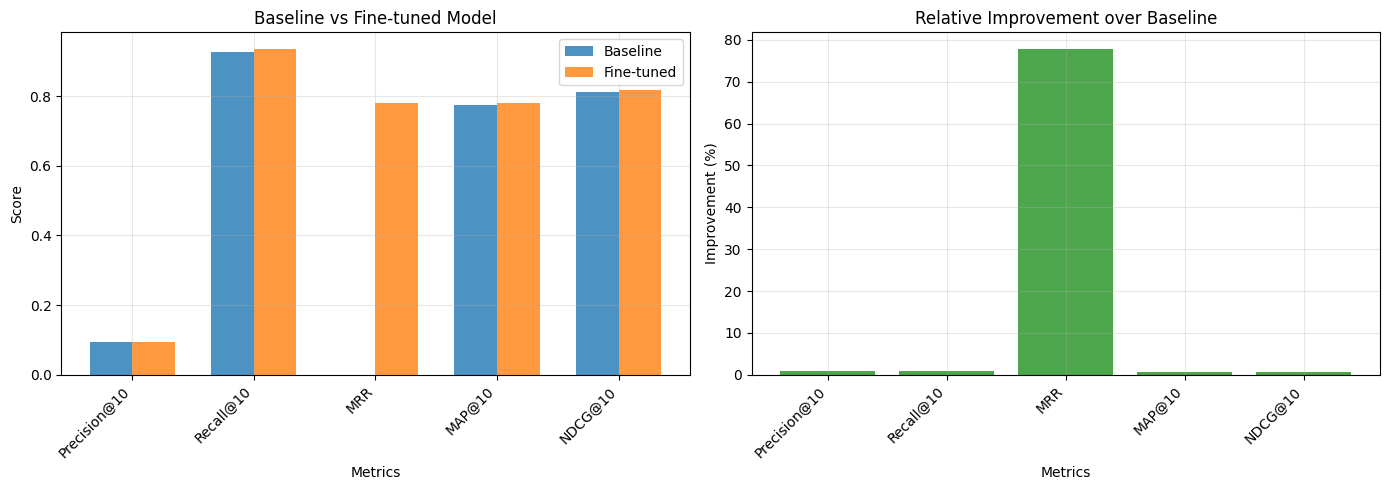


Improvement Summary
Precision@10.................. 0.0928 → 0.0938 (↑ 1.02%)
Recall@10..................... 0.9265 → 0.9359 (↑ 1.02%)
MRR........................... 0.0000 → 0.7788 (baseline was 0)
MAP@10........................ 0.7735 → 0.7786 (↑ 0.66%)
NDCG@10....................... 0.8110 → 0.8173 (↑ 0.77%)



In [25]:
# Compare with baseline (zero-shot only)
compare_with_baseline(test_metrics, baseline_results=baseline_results)

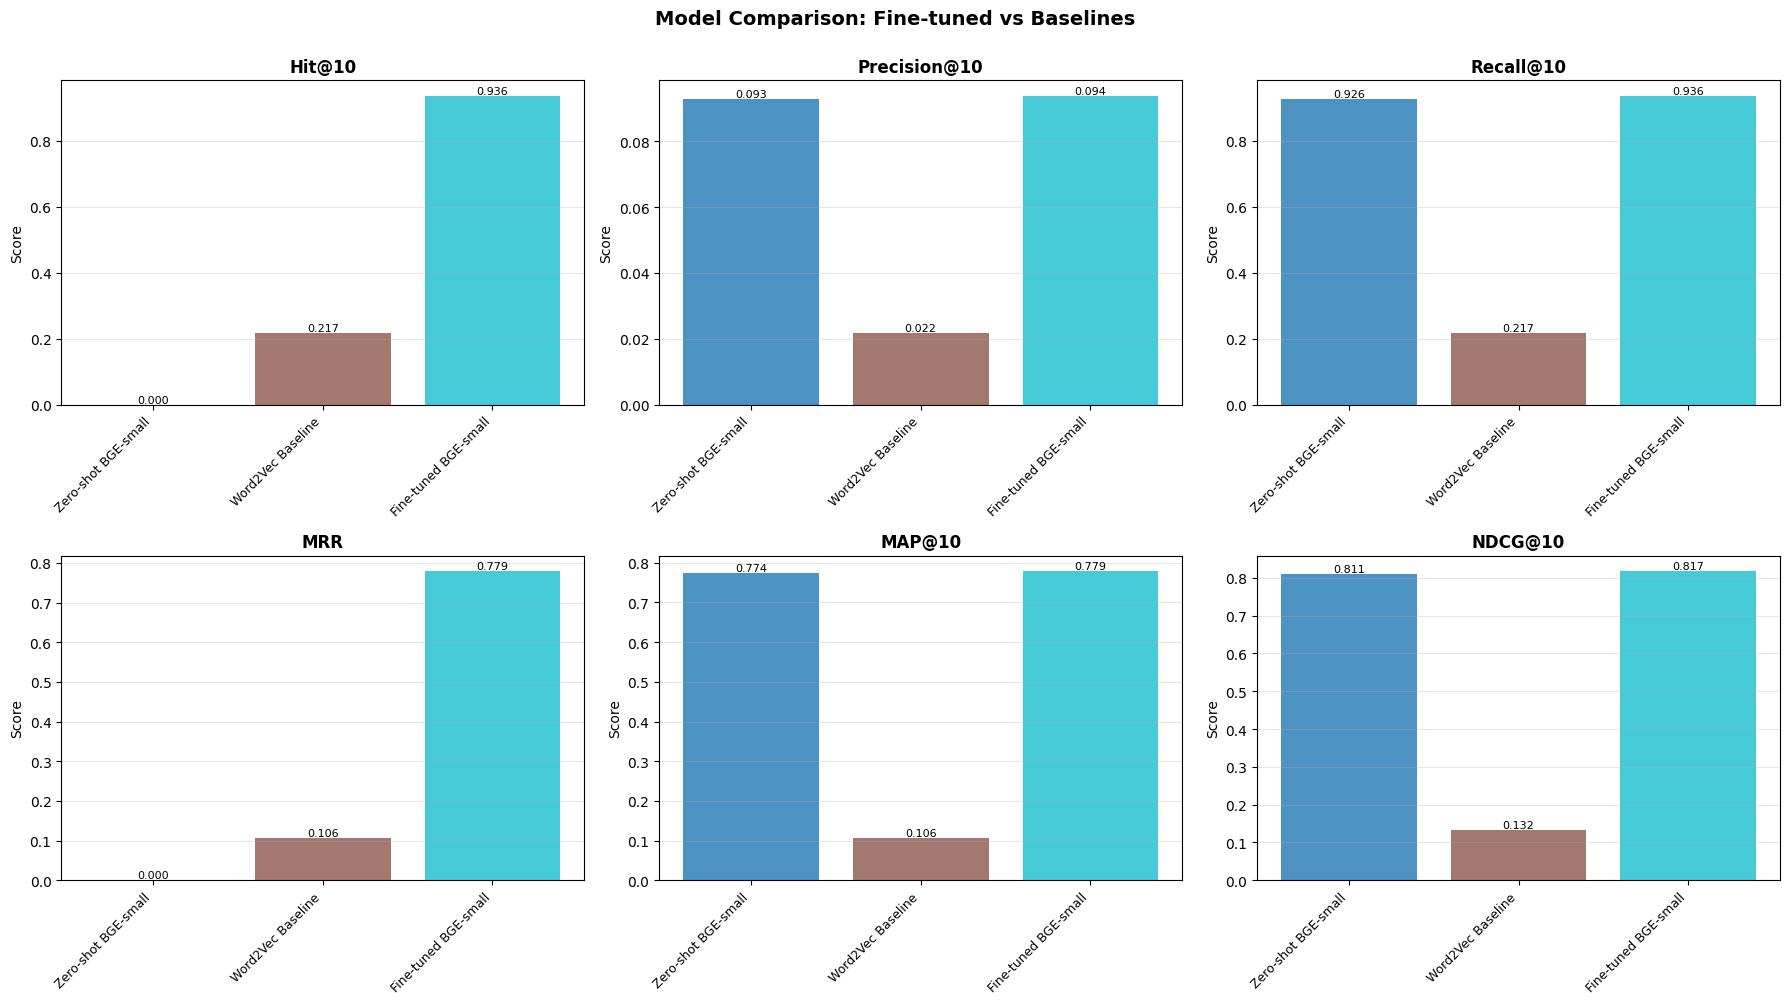


DETAILED MODEL COMPARISON

Model                          Hit@10Precision@10   Recall@10         MRR      MAP@10     NDCG@10
----------------------------------------------------------------------------------------------------
Zero-shot BGE-small            0.0000      0.0928      0.9265      0.0000      0.7735      0.8110
Word2Vec Baseline              0.2169      0.0217      0.2166      0.1057      0.1056      0.1317
Fine-tuned BGE-small           0.9359      0.0938      0.9359      0.7788      0.7786      0.8173



In [26]:
# Compare with all baseline models
logger.info("Generating comprehensive model comparison...")
compare_all_models(
    test_metrics, baseline_results, finetuned_name="Fine-tuned BGE-small"
)

### Analyze Individual Query Performance

Examine specific queries to understand model performance.

In [27]:
def analyze_query_performance(samples: List[Dict[str, Any]], num_examples: int = 5):
    """
    Analyze performance on individual queries

    Args:
        samples: Evaluation samples from evaluate_model_retrieval
        num_examples: Number of examples to display
    """
    # Calculate per-query metrics
    query_metrics = []

    for sample in samples:
        gt_set = set(str(x) for x in sample["ground_truth"])
        results = [str(x) for x in sample["contexts"]]

        # Hit@10
        hit = 1.0 if any(r in gt_set for r in results[:10]) else 0.0

        # Recall@10
        hits_count = sum(1 for r in results[:10] if r in gt_set)
        recall = hits_count / len(gt_set) if gt_set else 0.0

        # MRR
        mrr = 0.0
        for rank, r in enumerate(results, start=1):
            if r in gt_set:
                mrr = 1.0 / rank
                break

        query_metrics.append(
            {
                "query": sample["question"],
                "hit": hit,
                "recall": recall,
                "mrr": mrr,
                "num_relevant": len(gt_set),
                "retrieved": results[:10],
            }
        )

    # Sort by MRR (worst first)
    query_metrics.sort(key=lambda x: x["mrr"])

    print("\n" + "=" * 80)
    print(f"Worst {num_examples} Queries (by MRR)")
    print("=" * 80)

    for i, qm in enumerate(query_metrics[:num_examples], 1):
        print(f"\n{i}. Query: {qm['query'][:80]}...")
        print(
            f"   Hit@10: {qm['hit']:.0f} | Recall@10: {qm['recall']:.4f} | MRR: {qm['mrr']:.4f}"
        )
        print(f"   Relevant docs: {qm['num_relevant']}")

    print("\n" + "=" * 80)
    print(f"Best {num_examples} Queries (by MRR)")
    print("=" * 80)

    for i, qm in enumerate(query_metrics[-num_examples:][::-1], 1):
        print(f"\n{i}. Query: {qm['query'][:80]}...")
        print(
            f"   Hit@10: {qm['hit']:.0f} | Recall@10: {qm['recall']:.4f} | MRR: {qm['mrr']:.4f}"
        )
        print(f"   Relevant docs: {qm['num_relevant']}")

In [28]:
# Analyze query performance
analyze_query_performance(test_samples, num_examples=3)


Worst 3 Queries (by MRR)

1. Query: where is chromatin histones elongated...
   Hit@10: 0 | Recall@10: 0.0000 | MRR: 0.0000
   Relevant docs: 1

2. Query: which pathogen controls cell division and neurulation in mice...
   Hit@10: 0 | Recall@10: 0.0000 | MRR: 0.0000
   Relevant docs: 1

3. Query: which functional property determines the shape of chromatin...
   Hit@10: 0 | Recall@10: 0.0000 | MRR: 0.0000
   Relevant docs: 1

Best 3 Queries (by MRR)

1. Query: which of the following molecules is associated with obesity...
   Hit@10: 1 | Recall@10: 1.0000 | MRR: 1.0000
   Relevant docs: 1

2. Query: metabolic remodeling in glioblastoma multiforme...
   Hit@10: 1 | Recall@10: 1.0000 | MRR: 1.0000
   Relevant docs: 1

3. Query: which of these is a characteristic of aerobic glycolysis?...
   Hit@10: 1 | Recall@10: 1.0000 | MRR: 1.0000
   Relevant docs: 1


## 8. Results Visualization

Visualize training results and evaluation metrics.

In [29]:
# Configure matplotlib for notebook display
import matplotlib.pyplot as plt
import matplotlib

# For Jupyter/IPython environments
try:
    from IPython.core.getipython import get_ipython

    ipython = get_ipython()
    if ipython is not None:
        ipython.run_line_magic("matplotlib", "inline")
except Exception:
    pass

# Set default style
plt.style.use("default")
matplotlib.rcParams["figure.dpi"] = 100

In [30]:
def plot_evaluation_results(results_csv_path: str):
    """
    Plot evaluation results

    Args:
        results_csv_path: Path to the evaluation results CSV file
    """
    import matplotlib.pyplot as plt

    if not Path(results_csv_path).exists():
        logger.warning(f"Results file not found: {results_csv_path}")
        print(f"File not found: {results_csv_path}")
        print(
            f"Please make sure the model has been trained and evaluation results exist."
        )
        return

    # Read results
    df = pd.read_csv(results_csv_path)
    print(f"Loaded results with {len(df)} rows")
    print(f"Available columns: {df.columns.tolist()}")

    # Define metrics to plot (try both naming conventions)
    # sentence-transformers uses format: "cosine-NDCG@10"
    # Alternative format: "ndcg_at_10"
    metric_mappings = {
        "NDCG@10": ["cosine-NDCG@10", "ndcg_at_10"],
        "MAP@100": ["cosine-MAP@100", "map_at_100"],
        "Recall@10": ["cosine-Recall@10", "recall_at_10"],
        "Precision@10": ["cosine-Precision@10", "precision_at_10"],
    }

    # Find which metrics are available
    available_metrics = {}
    for display_name, possible_names in metric_mappings.items():
        for col_name in possible_names:
            if col_name in df.columns:
                available_metrics[display_name] = col_name
                break

    if not available_metrics:
        print(f"Warning: None of the expected metrics found in CSV")
        print(f"Available columns: {df.columns.tolist()}")
        print(f"\nTrying to plot all numeric columns...")

        # Fallback: plot all numeric columns except 'epoch' and 'steps'
        numeric_cols = df.select_dtypes(include=["number"]).columns.tolist()
        plot_cols = [c for c in numeric_cols if c not in ["epoch", "steps"]]

        if not plot_cols:
            print("No plottable columns found!")
            return

        available_metrics = {col: col for col in plot_cols[:4]}  # Max 4 plots

    print(f"\nPlotting metrics: {list(available_metrics.keys())}")

    # Create subplots
    n_metrics = len(available_metrics)
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()

    for i, (display_name, col_name) in enumerate(available_metrics.items()):
        ax = axes[i]
        ax.plot(
            df["epoch"],
            df[col_name],
            marker="o",
            linewidth=2,
            markersize=6,
            color="steelblue",
        )
        ax.set_title(display_name, fontsize=12, fontweight="bold")
        ax.set_xlabel("Epoch", fontsize=10)
        ax.set_ylabel("Score", fontsize=10)
        ax.grid(True, alpha=0.3, linestyle="--")

        # Add value annotations on points (only if not too many points)
        if len(df) <= 20:
            for x, y in zip(df["epoch"], df[col_name]):
                ax.annotate(
                    f"{y:.3f}",
                    (x, y),
                    textcoords="offset points",
                    xytext=(0, 5),
                    ha="center",
                    fontsize=7,
                    alpha=0.7,
                )

    # Hide unused subplots
    for i in range(n_metrics, 4):
        axes[i].set_visible(False)

    plt.suptitle("Training Evaluation Results", fontsize=14, fontweight="bold", y=1.00)
    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print("\n" + "=" * 70)
    print("Evaluation Results Summary")
    print("=" * 70)
    for display_name, col_name in available_metrics.items():
        best_idx = df[col_name].idxmax()
        best_epoch = df.loc[best_idx, "epoch"]
        best_score = df[col_name].max()
        final_score = df[col_name].iloc[-1]
        print(f"{display_name}:")
        print(f"  Best:  {best_score:.4f} (epoch {int(best_epoch)})")
        print(f"  Final: {final_score:.4f}")
        print(
            f"  Improvement: {((final_score - df[col_name].iloc[0]) / df[col_name].iloc[0] * 100):.2f}%"
        )
        print("=" * 70)
    for display_name, col_name in available_metrics.items():
        best_epoch = df.loc[df[col_name].idxmax(), "epoch"]
        best_score = df[col_name].max()
        final_score = df[col_name].iloc[-1]
        print(f"{display_name}:")
        print(f"  Best: {best_score:.4f} (epoch {int(best_epoch)})")
        print(f"  Final: {final_score:.4f}")
    print("=" * 60)


Loaded results with 15 rows
Available columns: ['epoch', 'steps', 'cosine-Accuracy@1', 'cosine-Accuracy@3', 'cosine-Accuracy@5', 'cosine-Accuracy@10', 'cosine-Precision@10', 'cosine-Recall@10', 'cosine-Precision@100', 'cosine-Recall@100', 'cosine-MRR@10', 'cosine-NDCG@10', 'cosine-NDCG@100', 'cosine-MAP@100']

Plotting metrics: ['NDCG@10', 'MAP@100', 'Recall@10', 'Precision@10']


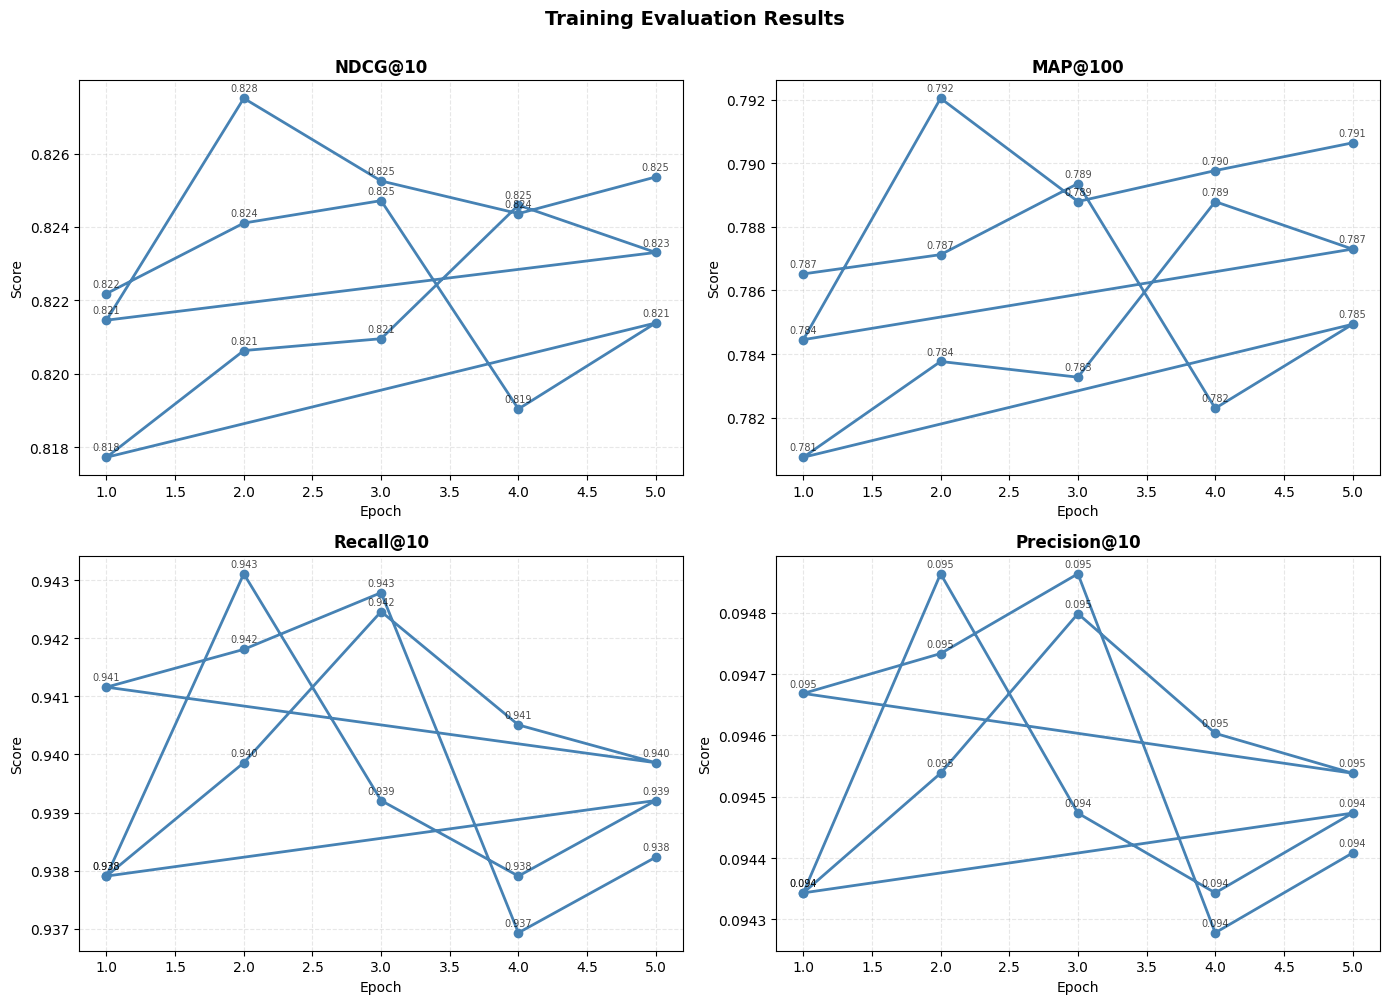


Evaluation Results Summary
NDCG@10:
  Best:  0.8275 (epoch 2)
  Final: 0.8254
  Improvement: 0.39%
MAP@100:
  Best:  0.7920 (epoch 2)
  Final: 0.7906
  Improvement: 0.52%
Recall@10:
  Best:  0.9431 (epoch 2)
  Final: 0.9382
  Improvement: 0.03%
Precision@10:
  Best:  0.0949 (epoch 2)
  Final: 0.0944
  Improvement: 0.07%


KeyError: 'NDCG@10'

In [31]:
# Visualize results (if training logs exist)
# Uncomment the lines below after training is complete
results_path = f"{OUTPUT_DIR}/eval/Information-Retrieval_evaluation_dev_results.csv"
plot_evaluation_results(results_path)

## 9. Summary

This notebook implements a complete semantic retrieval system, including:

1. **Data Loading and Preprocessing**: Load SciFact dataset from HuggingFace and convert to BEIR format
2. **Model Training**: Fine-tune sentence-transformers model using MultipleNegativesRankingLoss
3. **Evaluation**: Evaluate model performance on test set with multiple retrieval metrics
4. **Inference**: Perform semantic retrieval using the trained model

### Custom Configuration

You can modify the following parameters to customize training:

- `MODEL_NAME`: Base model (default: "BAAI/bge-small-en-v1.5")
- `BATCH_SIZE`: Batch size (default: 32)
- `EPOCHS`: Number of epochs (default: 6)
- `LEARNING_RATE`: Learning rate (default: 3e-5)
- `OUTPUT_DIR`: Model save path